## Inference Pipeline

## Import dependencies

In [1]:
from auth.auth import S3Connector
from utils.utils import extract_s3_path_from_url
from utils.stac_client import get_product, get_product_content
from dotenv import load_dotenv
import os
import pystac_client
from utils.utils import load_config
import random

In [2]:
# Get credentials from environment variables
load_dotenv()
ACCESS_KEY_ID = os.environ.get("ACCESS_KEY_ID")
SECRET_ACCESS_KEY = os.environ.get("SECRET_ACCESS_KEY")
ENDPOINT_URL = 'https://eodata.dataspace.copernicus.eu'
ENDPOINT_STAC = "https://stac.dataspace.copernicus.eu/v1/"
BUCKET_NAME = "eodata"
path = "/home/ubuntu/project/sentinel-2-ai-processor/src/cfg/config_dataset.yaml"

config = load_config(config_path=path)

bbox = config["query"]["bbox"]
bbox

[3.2833, 45.3833, 11.2, 50.1833]

In [3]:
catalog = pystac_client.Client.open(ENDPOINT_STAC)
connector = S3Connector(
    endpoint_url=ENDPOINT_URL,
    access_key_id=ACCESS_KEY_ID,
    secret_access_key=SECRET_ACCESS_KEY,
    region_name='default'
)
# Get S3 client and resource from the connector instance
s3 = connector.get_s3_resource()
s3_client = connector.get_s3_client()
buckets = connector.list_buckets()

In [4]:
# Search for Sentinel-2 products
items_l1c= catalog.search(
    collections=['sentinel-2-l1c'],
    bbox=bbox,
    datetime="2024-05-01/2024-06-01",
    query=["eo:cloud_cover<30"]
).item_collection()

In [5]:
selected_item = random.choice(items_l1c)
selected_item

<Item id=S2B_MSIL1C_20240512T100559_N0510_R022_T32TPR_20240512T124602>

In [6]:
bucket = s3.Bucket(BUCKET_NAME)
product_url = extract_s3_path_from_url(selected_item.assets['B02'].href)
# file_path = get_product(s3_resource=s3_client, bucket_name=BUCKET_NAME,
#                              object_url=product_url,
#                              output_path=".")
product_content = get_product_content(s3_client=s3_client, bucket_name=BUCKET_NAME,
                                     object_url=product_url)

Successfully downloaded Sentinel-2/MSI/L1C/2024/05/12/S2B_MSIL1C_20240512T100559_N0510_R022_T32TPR_20240512T124602.SAFE/GRANULE/L1C_T32TPR_A037514_20240512T101813/IMG_DATA/T32TPR_20240512T100559_B02.jp2


In [9]:
import numpy as np
from PIL import Image
import io

bands = { 1: 'B02', 2: 'B03', 3: 'B04'}
# bands = { 1: 'B02_60m', 2: 'B03_60m', 3: 'B04_60m'}

# Loop through each band
band_data = []
for band_index, band_name in bands.items():
    print(f"Band {band_name}")
    product_url = extract_s3_path_from_url(selected_item.assets[band_name].href)
    product_content = get_product_content(s3_client=s3_client, bucket_name=BUCKET_NAME,
                                     object_url=product_url)
    product_content = Image.open(io.BytesIO(product_content))
    resized_image = product_content.resize((1830, 1830))
    product_content = np.array(product_content)
    band_data.append(product_content)
    print(f"Successfully downloaded product: {product_url}")

Band B02
Successfully downloaded Sentinel-2/MSI/L1C/2024/05/12/S2B_MSIL1C_20240512T100559_N0510_R022_T32TPR_20240512T124602.SAFE/GRANULE/L1C_T32TPR_A037514_20240512T101813/IMG_DATA/T32TPR_20240512T100559_B02.jp2


/home/ubuntu/miniconda3/envs/ai_processor/lib/python3.12/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (120560400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Successfully downloaded product: Sentinel-2/MSI/L1C/2024/05/12/S2B_MSIL1C_20240512T100559_N0510_R022_T32TPR_20240512T124602.SAFE/GRANULE/L1C_T32TPR_A037514_20240512T101813/IMG_DATA/T32TPR_20240512T100559_B02.jp2
Band B03
Successfully downloaded Sentinel-2/MSI/L1C/2024/05/12/S2B_MSIL1C_20240512T100559_N0510_R022_T32TPR_20240512T124602.SAFE/GRANULE/L1C_T32TPR_A037514_20240512T101813/IMG_DATA/T32TPR_20240512T100559_B03.jp2
Successfully downloaded product: Sentinel-2/MSI/L1C/2024/05/12/S2B_MSIL1C_20240512T100559_N0510_R022_T32TPR_20240512T124602.SAFE/GRANULE/L1C_T32TPR_A037514_20240512T101813/IMG_DATA/T32TPR_20240512T100559_B03.jp2
Band B04
Successfully downloaded Sentinel-2/MSI/L1C/2024/05/12/S2B_MSIL1C_20240512T100559_N0510_R022_T32TPR_20240512T124602.SAFE/GRANULE/L1C_T32TPR_A037514_20240512T101813/IMG_DATA/T32TPR_20240512T100559_B04.jp2
Successfully downloaded product: Sentinel-2/MSI/L1C/2024/05/12/S2B_MSIL1C_20240512T100559_N0510_R022_T32TPR_20240512T124602.SAFE/GRANULE/L1C_T32TPR_A037

In [10]:
x_data = np.dstack(band_data)

In [ ]:
def normalize(data_array):
    """
    Normalize the data array to the range [0, 1].
    """
    normalized_data = []
    valid_masks= []
    for i in range(data_array.shape[2]):
        band_data = data_array[:, :, i]
        valid_mask = (band_data > 0)
        result = band_data.copy().astype(np.float32)
        result[valid_mask] = result[valid_mask] / 10000
        result[valid_mask] = np.clip(result[valid_mask], 0, 1)
        result[~valid_mask] = 0.0
        normalized_data.append(result)
        valid_masks.append(valid_mask)
    return np.dstack(normalized_data), np.dstack(valid_masks)


In [12]:
path = "/home/ubuntu/project/sentinel-2-ai-processor/src/results/2025-05-09_19-12-13"
config = load_config(config_path="/home/ubuntu/project/sentinel-2-ai-processor/src/results/2025-05-09_19-12-13/config.yaml")

In [13]:
from model_zoo.models import define_model
import torch
from utils.torch import load_model_weights

weights_path = f"/home/ubuntu/project/sentinel-2-ai-processor/src/results/2025-05-09_19-12-13/checkpoints/best_model.pth"
model = define_model(name=config["MODEL"]["model_name"],
                    encoder_name=config["MODEL"]["encoder_name"],
                    in_channel=len(bands),
                    out_channels=len(bands),
                    activation=config["MODEL"]["activation"])

# Load best model weights
model = load_model_weights(model=model, filename=weights_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/home/ubuntu/miniconda3/envs/ai_processor/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-11 07:42:29.025 | INFO     | utils.torch:load_model_weights:103 - 
 -> Loading encoder weights from /home/ubuntu/project/sentinel-2-ai-processor/src/results/2025-05-09_19-12-13/checkpoints/best_model.pth



In [14]:
import cv2
resize = 1024
x_data, x_mask = normalize(x_data)
x_data = cv2.resize(x_data, (resize, resize), interpolation=cv2.INTER_AREA)
x_mask = cv2.resize(x_mask.astype(np.uint8), (resize, resize), interpolation=cv2.INTER_NEAREST).astype(bool)

In [15]:
valid_mask = x_mask

# Prepare tensors for inference
x_tensor = torch.from_numpy(x_data).float().permute(2, 0, 1).unsqueeze(0).to(device)  # [1, C, H, W]

# Inference
model.eval()
with torch.no_grad():
    pred_tensor = model(x_tensor)

# Convert tensors to NumPy
x_np = x_tensor.cpu().numpy()[0].transpose(1, 2, 0)       # [H, W, C]
pred_np = pred_tensor.cpu().numpy()[0].transpose(1, 2, 0) # [H, W, C]

In [16]:
# Apply mask: set invalid pixels to 0
x_np[~valid_mask] = 0.0

pred_np[~valid_mask] = 0.0

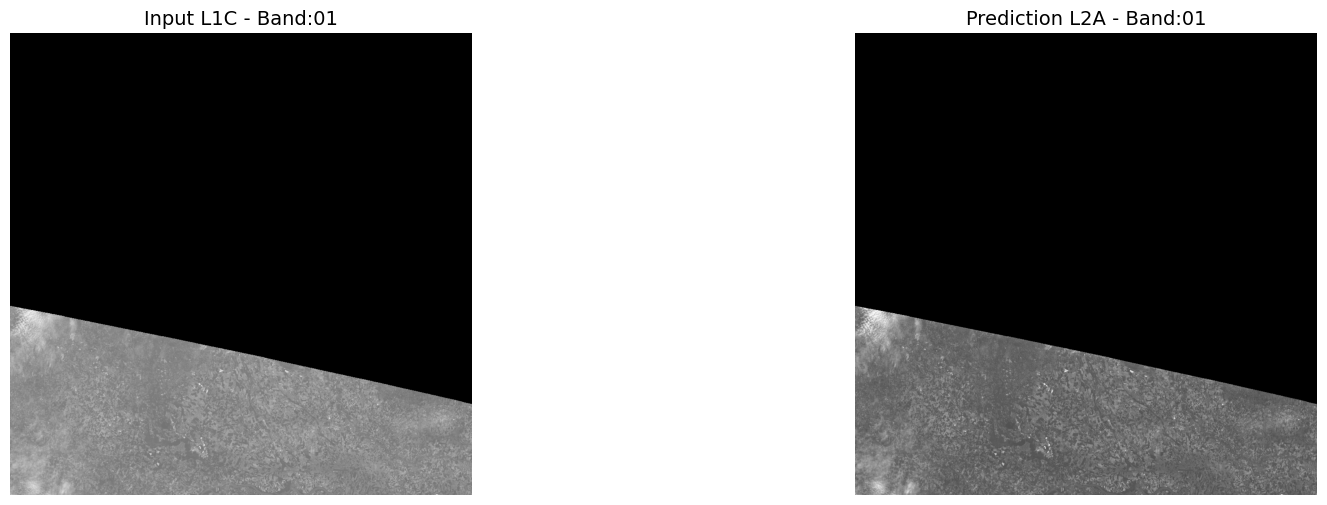

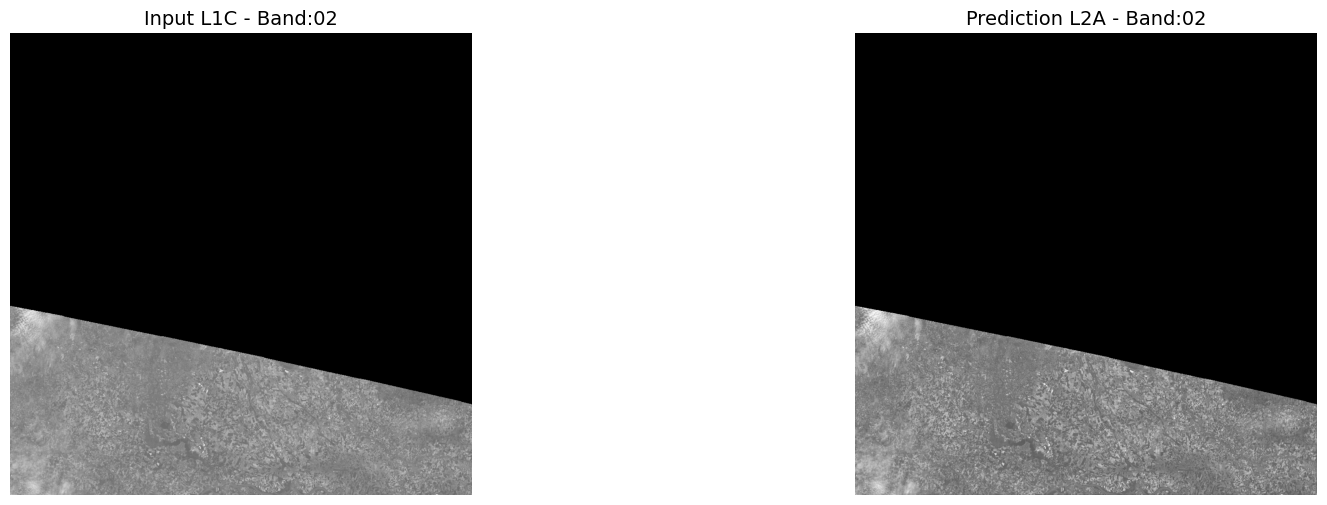

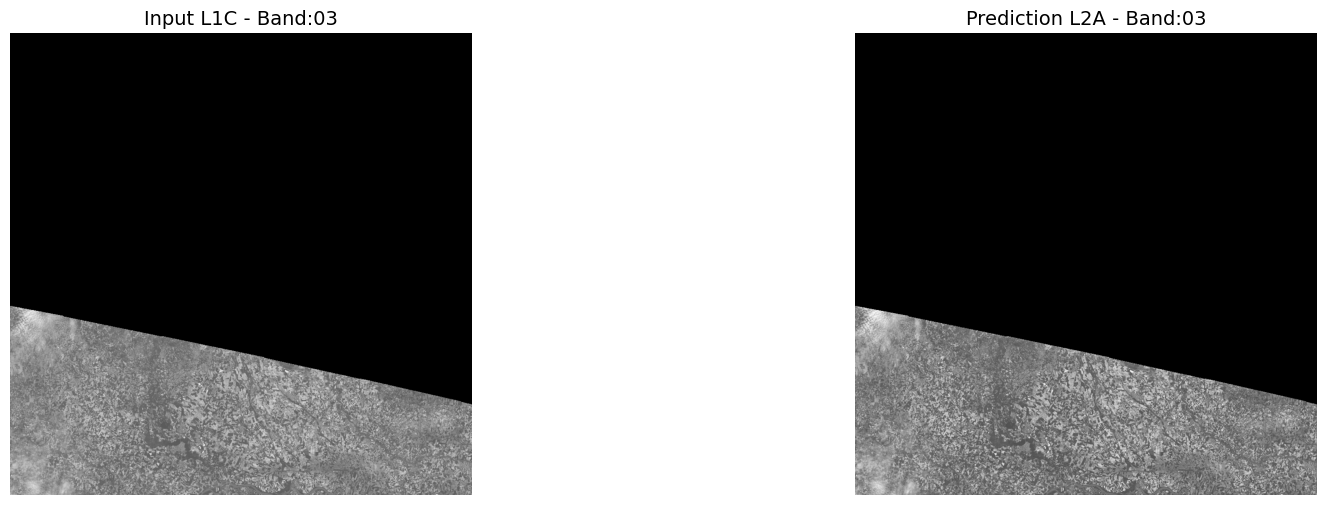

In [17]:
import matplotlib.pyplot as plt
cmap = "Grays_r"
# Plot results for each band
for idx, band in enumerate(bands):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    vmin = 0
    # Input
    im0 = axs[0].imshow(x_np[:, :, idx], cmap=cmap, vmin=x_np[:, :, idx].min(), vmax=x_np[:, :, idx].max())
    axs[0].set_title(f"Input L1C - Band:0{band}", fontsize=14)
    axs[0].axis('off')
    # plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
    # Prediction
    im2 = axs[1].imshow(pred_np[:, :, idx], cmap=cmap, vmin=vmin, vmax=pred_np[:, :, idx].max())
    axs[1].set_title(f"Prediction L2A - Band:0{band}", fontsize=14)
    axs[1].axis('off')
    # plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
